## Lyrics Generation using RNN

The "Lyrics Generation using RNN" project aims to create an AI-powered system that generates song lyrics similar to Taylor Swift's style. By utilizing a pre-trained RNN model, the project generates lyrics that mimic the patterns and themes found in the input training lyrics.

# Key Features

RNN Model for Text Generation: The project employs a pre-trained RNN model, likely LSTM-based, which has been trained on a diverse set of song lyrics. This model has learned patterns in lyrics and can generate coherent text based on a given seed text.

Lyric Preprocessing: A dedicated "LyricProcessor" class handles the preprocessing of lyrics. This includes text cleaning, converting words to indices, and providing utilities to interact with the text data.

Lyric Generation Methods: The "LyricGenerator" class encapsulates the core functionality of the project. It contains methods to generate lyrics based on a seed text and to create multiple sample lyrics. The generated lyrics maintain the style and thematic elements of the training dataset.

Sample Lyric Showcase: The project includes a method to showcase a specified number of sample lyrics. This allows users to quickly see the system's output and provides inspiration for songwriting.

In [1]:
import pandas as pd
import numpy as np

import math
import sys
import random
import re
import string
import collections
from collections import Counter
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from numpy import array
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
from textblob import TextBlob
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import to_categorical
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.callbacks import LambdaCallback
from keras.layers import Bidirectional
from keras import backend as K
from keras.optimizers import RMSprop

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
from nltk import word_tokenize

from enum import Enum
class SequenceType(Enum):
    PADDED_SEQUENCES = 'padded_sequences'

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Text Cleaning and Preprocessing

URL Removal: URLs are removed from the text using regular expressions.

Special Characters and Digits Removal: All non-alphanumeric characters and digits are removed from the text. This helps in keeping only the alphabetic words.

Lowercasing: The text is converted to lowercase to ensure consistency and avoid treating the same words differently based on case.

Punctuation Removal: Punctuation marks are removed from the text.

Tokenization: The text is tokenized into individual words using the word_tokenize function, splitting the text into a list of words.

Reconstruction: The cleaned words are rejoined to form the cleaned text.

**Getting Training and Validation Sets:**

Split Data: Splitting the dataset into training and validation sets. Then gets the sequences for training and validation.

Converting to 3D Sequences: Then converts the sequences to a 3D format required by many sequence models. This private method reshapes the sequences into the desired 3D format.

In [2]:
class LyricProcessor:

  def __init__(self, file_path, rows=2000):
    # rows: number of rows processed
    self.rows = rows
    self.file_path = file_path
    self.lyrics = self.__clean_lyrics(file_path, rows)

    # self.stop_words = set(stopwords.words('english'))
    self.lemmatizer = WordNetLemmatizer()
    self.label_dict, self.reverse_dict = self.__build_vocab_by_word()
    self.vocab_size = len(self.label_dict)


  def load_data(self):
    try:
      # Load the data from CSV file (assuming the CSV has a 'Lyrics' column)
      data = pd.read_csv(self.file_path)
      return data

    except FileNotFoundError:
      raise FileNotFoundError(f"File '{self.file_path}' not found.")

    except Exception as e:
      raise Exception("Error occurred while loading data:", str(e))


  # Assemble all words back into a single word, and replace special chars
  def clean_text(self, text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions (@usernames)
    text = re.sub(r'@\w+', '', text, flags=re.MULTILINE)
    # Remove hashtags (#hashtags)
    text = re.sub(r'#\w+', '', text, flags=re.MULTILINE)
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text into words
    words = word_tokenize(text)
    # Remove stopwords and perform lemmatization
    # words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stop_words]
    # Reconstruct the cleaned text
    cleaned_text = ' '.join(words)
    return cleaned_text

  def __clean_lyrics(self, file_path, rows):
    try:
        # Read the CSV file using pandas
        df = pd.read_csv(file_path)

        col_name = 'Lyrics'
        if col_name not in df.columns:
            raise ValueError(f"'{col_name}' column not found in the CSV file.")
        df[col_name] = df[col_name].astype(str)

        # Drop duplicate rows
        df.drop_duplicates(subset=[col_name], inplace=True)
        # Drop rows with empty lyrics text
        df.dropna(subset=[col_name], inplace=True)

        # Clean lyrics text
        df['cleaned_lyrics'] = df[col_name].apply(self.clean_text)
        lines = df['cleaned_lyrics'].tolist()

        # Limit the number of rows
        lines = lines[:rows]

        print(f'...Loaded {len(lines)} lyrics from {self.file_path}.')
        return lines

    except Exception as e:
        print("Error occurred while cleaning data:", str(e))
        return None


  def __build_vocab_by_word(self):
    words = [word for line in self.lyrics for word in line.split()]
    n_words = len(set(words))

    count = [['UNK', 0]]  # Add 'UNK' as a placeholder for unknown words
    count.extend(collections.Counter(words).most_common(n_words))

    dictionary = {word: index for index, (word, _) in enumerate(count)}
    unk_count = sum(1 for word in words if word not in dictionary)
    count[0][1] = unk_count

    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    real_vocab_size = len(dictionary)

    print('...Loaded {0} total words and {1} unique words'.format(len(words), real_vocab_size))
    # print('...UNK represents {:.1%} of all words.'.format(unk_count / len(words)))
    print('...Most common words (+UNK)', count[:15])
    return dictionary, reversed_dictionary


  # Private method to shuffle two nparrays at the same time.
  def __shuffle(self, a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

  # Public method to get a label by its index
  def get_label_by_index(self, index):
    return self.reverse_dict[index]

  # Public method to get an index by a label
  def get_index_by_label(self, label):
    try:
      return self.label_dict[label]
    except:
       return 0 # UNK

  def get_train_valid_set(self, sequence_length, sequence_type = SequenceType.PADDED_SEQUENCES, valid_percent=0.2):
    assert 0 <= valid_percent <= 1, "valid_percent must be between 0 and 1."

    X, y = self.__get_train_valid_sequences(sequence_length, sequence_type)

    valid_index = int(len(X) * (1 - valid_percent))
    X_train, y_train = X[:valid_index], y[:valid_index]
    X_valid, y_valid = X[valid_index:], y[valid_index:]

    # Reshape X_train, X_valid to 3D sequences
    X_train = self.__convert_to_3d_sequences(X_train)
    X_valid = self.__convert_to_3d_sequences(X_valid)

    return X_train, y_train, X_valid, y_valid

  def __convert_to_3d_sequences(self, sequences):
    num_samples = len(sequences)
    sequence_length = len(sequences[0])
    embedding_size = 1  # Change this if using word embeddings

    return sequences.reshape(num_samples, sequence_length, embedding_size)

  def __get_train_valid_sequences(self, sequence_length, sequence_type):
    X, y = self.__get_train_valid_set_padded_sequences(sequence_length)

    # Normalize and shuffle the sequences
    X_normalized = X.astype(float) / self.vocab_size
    y_normalized = to_categorical(y)

    X_shuffled, y_shuffled = self.__shuffle(X_normalized, y_normalized)
    return X_shuffled, y_shuffled

  def __get_train_valid_set_padded_sequences(self, sequence_length):
    X = []
    y = []

    for line in self.lyrics:
      x = np.zeros(sequence_length).tolist()
      words = line.split()

      for w in range(len(words)):
        for i in range(sequence_length):
          row = []
          row.append(words[w])

          for j in range(sequence_length - 1):
            if (j < i and (w + j + 1) < len(words)):
              row.append(words[w + j + 1])
            else:
              row.insert(0, '')

          if (w + i + 1 < len(words)):
            X.append([self.get_index_by_label(word) for word in row])
            y.append(self.get_index_by_label(words[w + i + 1]))

    return np.array(X), np.array(y)

# Method Signature

The code sets up a Sequential model using Keras.
It adds an LSTM layer as the input layer with the specified number of neurons and input shape. The return_sequences parameter is set based on whether this is the last LSTM layer or not.
If dropout is greater than 0, a Dropout layer is added after each LSTM layer to prevent overfitting.
Additional LSTM layers are added in a loop, following a similar pattern as the input layer.
The final layer is a Dense layer with a softmax activation function, suitable for multi-class classification problems.
Model Compilation:

The model is compiled with categorical cross-entropy loss and the Adam optimizer.

In [3]:
class RNNProcessor:

  def create_and_train_rnn_model(self, X_train, y_train, X_valid, y_valid, batch_size=256, epochs=100, neurons=500, lstm_layers=1, learning_rate=0.01, dropout=0.2):
    K.clear_session();

    model = Sequential()

    # Input Layer
    rs = True
    if(lstm_layers == 1):
      rs = False

    model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=rs))
    if(dropout > 0):
      model.add(Dropout(dropout))

    for layer in range(1, lstm_layers):
      rs = True
      if(layer == lstm_layers - 1):
          rs = False

      model.add(LSTM(neurons, return_sequences=rs))
      if(dropout > 0):
        model.add(Dropout(dropout))

    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

    self.__plot_history(history)

    return model

  def __plot_history(self, history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model Train vs Validation Loss', fontdict={'fontsize': 12, 'fontweight': 'medium'})
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    axes[0].legend(['Train', 'Validation'], loc='upper right')

    axes[1].plot(history.history['accuracy'])
    axes[1].plot(history.history['val_accuracy'])
    axes[1].set_title('Model Train vs Validation Accuracy', fontdict={'fontsize': 12, 'fontweight': 'medium'})
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    axes[1].legend(['Train', 'Validation'], loc='upper right')

    fig.tight_layout()
    plt.show()

# Employs Pre-trained Models to Produce Lyrics

Initializes the generator with a text processor, model, and output length.

Generates text based on input seed text, predicting next elements using the model's probabilities. Utilizes a sampling strategy to select next elements.

Generates a specified number of diverse sample texts. Selects random seed texts and generates full text using generate_text.

In [4]:
class LyricGenerator:

  def __init__(self, lyric_processor, model, lyric_length=140):
    self.lyric_processor = lyric_processor
    self.model = model
    self.lyric_length = lyric_length

  def lyric(self, seed_text):
    seed_text = self.lyric_processor.clean_text(seed_text)  # Same cleanup on seed text as we did for training data
    full_lyric = seed_text

    # Convert the seed text into a list of integers (making sure to left pad if seed text is less than model input size)
    seed_words = seed_text.lower().split()

    if(len(seed_words) > self.model.input_shape[1]):
      seed_words = seed_words[:self.model.input_shape[1]]

    assert len(seed_words) <= self.model.input_shape[1], 'Seed text should have less than {0} words!'.format(self.model.input_shape[1])

    words = np.zeros(self.model.input_shape[1]).tolist()
    for i in range(len(seed_words)):
      words[self.model.input_shape[1] - len(seed_words) + i] = self.lyric_processor.get_index_by_label(seed_words[i])

    # Loop until we have a full lyric
    while len(full_lyric) < self.lyric_length:
      x = np.reshape(words, (1, len(words), 1))
      x = x / float(self.lyric_processor.vocab_size)
      predictions = model.predict(x, verbose=0)
      word_idx = self.__sample(predictions[-1], temperature=0.9)
      word = self.lyric_processor.get_label_by_index(word_idx)
      full_lyric = full_lyric + ' ' + word

      words.append(word_idx)
      words = words[1:len(words)]

    return full_lyric

  def generate_sample_lyrics(self, samples):
    seed_length = 5  # Length of the seed text for the sample
    seed_text = []   # Array of items to generate samples from
    seeds_found = 0

    print('')
    print('Showing {0} Sample Lyrics'.format(samples))
    print('')

    while seeds_found < samples:
      text = random.sample(self.lyric_processor.lyrics, 1)[0]
      words = text.split()
      if(len(words) >= seed_length):
        seed_text.append(' '.join([str(word) for word in words[:5]]))
        seeds_found = seeds_found + 1

    for i in range(len(seed_text)):
      sample = self.lyric(seed_text[i])
      print(sample)
      print('')

  # From https://keras.io/examples/lstm_text_generation/
  def __sample(self, preds, temperature=1.0):
    if temperature <= 0:
      return np.argmax(preds)

    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)

    return np.argmax(probas)

In [ ]:
processor = LyricProcessor(path_to_data)
X_train, y_train, X_valid, y_valid = processor.get_train_valid_set(sequence_length=7, valid_percent=0.1, sequence_type='padded_sequences')

...Loaded 147 lyrics from gdrive/My Drive/Colab Notebooks/taylor_swift_genius_data.csv.
...Loaded 54681 total words and 3523 unique words
...Most common words (+UNK) [['UNK', 0], ('you', 2626), ('i', 2420), ('the', 1901), ('and', 1484), ('me', 952), ('to', 947), ('a', 903), ('it', 864), ('my', 805), ('in', 788), ('like', 607), ('of', 576), ('your', 576), ('im', 490)]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 3523)              905411    
                                                                 
Total params: 1,169,603
Trainable params: 1,169,603
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
666/666 [==============================] - 119s 176ms/step - loss: 6.1198 - accuracy: 0.0474 - val_loss: 6.0349 - val_accuracy: 0.0458
Epoch 2/200
666/666 [==============================] - 113s 170ms/step - loss: 6.0217 - accuracy: 0.0492 - val_loss: 5.9952 - val_accuracy: 0.0470
Epoch 3/200
666/

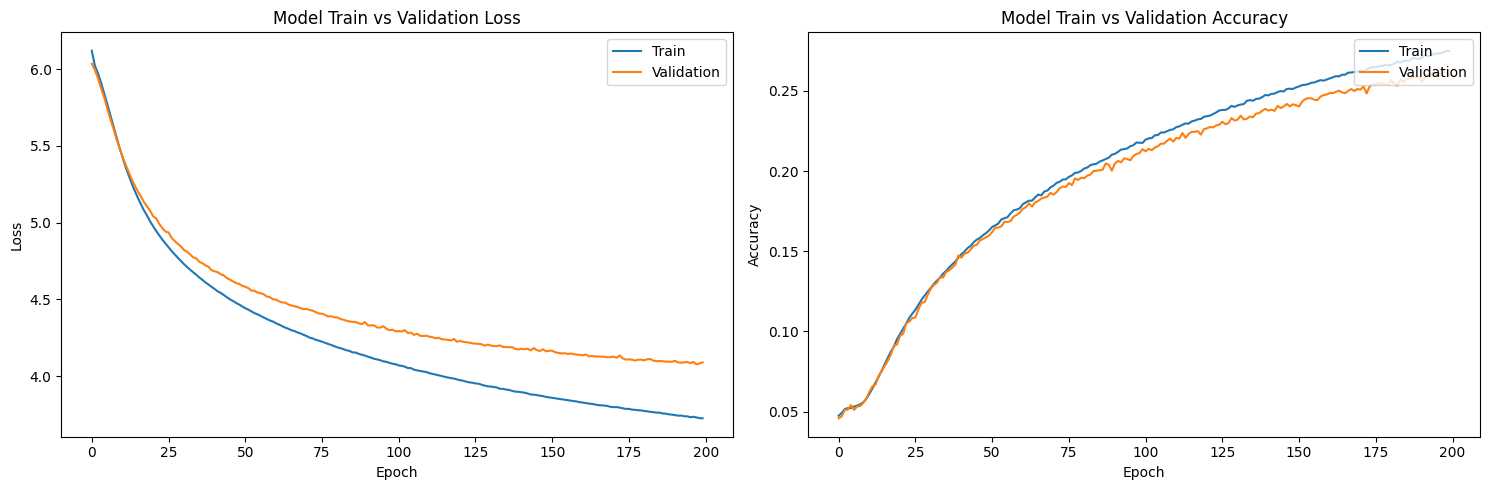

In [ ]:
rnn = RNNProcessor()
model = rnn.create_and_train_rnn_model(X_train, y_train, X_valid, y_valid, batch_size=512, epochs=200, neurons=256, lstm_layers=1, learning_rate=0.001, dropout=0.2)

In [ ]:
generator = LyricGenerator(processor, model, lyric_length=140)
generator.generate_sample_lyrics(10)


Showing 10 Sample Lyrics



<ipython-input-13-a7a2034eb9bb>:65: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


i took a chance i do of think of well thing all crowd in wishing for the red there you eyes i alone baby about when its i never and like and

this aint for the best york reputations of gon im meet im like im winestained plans i your little you might you blame out im and are i i love

hey hey hey hey hey and might there red you beautiful if see you could its do i you want are like you look wan i love were the i snow i here

i can see you standing just the all party it need have so do i i you wan my said your drive out friends who it i this i and hope i you i pull

we were in the backseat on the the i of just is line but a say and what all and you you i my might can i i a i youre how i players but a just

we were both young when but first saw you not be daylight them it can and you that like your know snow to was now if know like no know the acted

what did you think id na hear you you i never a now your marvelous years it a drives thinking but you mothers on her me run and reputation yo